Neste notebook serão realizadas previsões para os anos de 2023 e 2024. 

In [1]:
import numpy as np
import pandas as pd
import preprocess_data as prep
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from models import build_baseline, train_model_using_cross_val, sum_regions_predictions
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)


Inicialmente iremos treinar os modelo usando os dados até 2023 para prever o ano de 2023.

In [2]:
STATE = 'CE'
TEST_YEAR = 2023

In [3]:
df = prep.load_cases_data()
df = df.loc[df.uf == STATE]
enso = prep.load_enso_data()

# generate the samples to train and test based on the regional data 
X_train, y_train = prep.generate_regional_train_samples(df, enso, TEST_YEAR, columns_to_normalize=['casos','epiweek', 'enso', 'R0', 'total_cases',
                                                                                                  'peak_week', 'perc_geocode'], episcanner = True)

In [4]:
X_train.shape

(220, 89, 8)

In [5]:
X_train.shape

(220, 89, 8)

In [6]:
y_train.shape

(220, 52)

Um passo importante do modelo é a definição da loss do modelo, ela será definida abaixo.  

In [8]:
LOSS = 'mse'

In [9]:
batch_size = 4
model = build_baseline( hidden=64, features=8, predict_n=52, look_back=89, loss=LOSS, 
                  stateful = False, batch_size = batch_size,  optimizer = Adam(learning_rate=0.001), activation = 'relu')

model 

/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (4, 89, 8)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (4, 89, 64)            │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (4, 89, 64)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (4, 64)                │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (4, 64)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (4, 52)                │         3,380 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,092 (215.20 KB)

 Trainable params: 55,092 (215.20 KB)

 Non-trainable params: 0 (0.00 B)

None


<Functional name=functional, built=True>

In [10]:
%%time 
model = train_model_using_cross_val(model, X_train, y_train, n_splits=4, epochs = 150,
                                verbose = 0,
                                batch_size = batch_size, 
                                monitor = 'val_loss',
                                min_delta = 0,
                                patience = 15)

Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
CPU times: user 21.2 s, sys: 3.45 s, total: 24.7 s
Wall time: 23.4 s


In [10]:
# save the model
model.save(f'saved_models/model_{STATE}_{TEST_YEAR-1}_notebook.keras')


Aplicando o modelo para 2023:

In [11]:
df_preds_23 = sum_regions_predictions(model, df, enso,TEST_YEAR,['casos','epiweek', 'enso', 'R0', 'total_cases',
                                                                                                  'peak_week', 'perc_geocode'], True, False )

In [12]:
df_w = df.loc[df.uf == STATE][['casos']].resample('W-SUN').sum()

df_w = prep.add_epiweek_label(df_w)

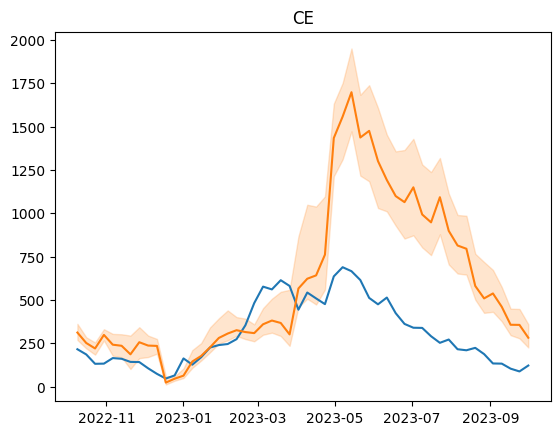

In [13]:
fig, ax = plt.subplots()

ax.plot(df_w.loc[df_w.year == TEST_YEAR].casos, label = 'Data')

ax.plot(df_preds_23.dates, df_preds_23.preds, label = 'preds')

ax.fill_between( df_preds_23.dates, df_preds_23.lower, df_preds_23.upper, color = 'tab:orange', alpha = 0.2)

ax.set_title(f'{STATE}')

plt.show()

Para fazer as previsões para 2024 iremos retreinar o modelo usando os dados de 2023: 

Dúvida: Devo retreinar tudo novamente mas usando o mesmo modelo como start já que a normalização dos dados mudam?? Ou só treinar usando os dados de 2024 da maneira que eu venho fazendo?

In [14]:
TEST_YEAR = 2024

In [15]:
#regional samples
X_train, y_train = prep.generate_regional_train_samples(df, enso, TEST_YEAR,['casos','epiweek', 'enso', 'R0', 'total_cases',
                                                                                                  'peak_week', 'perc_geocode'], True, False, min_year = 2023)

In [16]:
X_train.shape

(22, 89, 8)

Retrain the model and save:

In [17]:
model.compile(loss=LOSS, optimizer = Adam(learning_rate = 0.0001), metrics=["accuracy", "mape", "mse"])

TB_callback = TensorBoard(
            log_dir="./tensorboard",
            histogram_freq=0,
            write_graph=True,
            write_images=True,
            update_freq='epoch',
            # embeddings_freq=10
        )

hist = model.fit(
            X_train,
            y_train,
            batch_size=4,
            epochs=100,
            verbose=0,
            callbacks=[TB_callback, EarlyStopping(monitor='loss', min_delta=0, patience=20)]
        )

# save the model
model.save(f'saved_models/model_{STATE}_{TEST_YEAR-1}_notebook.keras')


Aplicando o modelo para 2024:

In [18]:
%%time
df_preds_24 =  sum_regions_predictions(model, df, enso,TEST_YEAR,['casos','epiweek', 'enso', 'R0', 'total_cases',
                                                                                                  'peak_week', 'perc_geocode'], True, False )

CPU times: user 5min 30s, sys: 1.44 s, total: 5min 32s
Wall time: 5min 42s


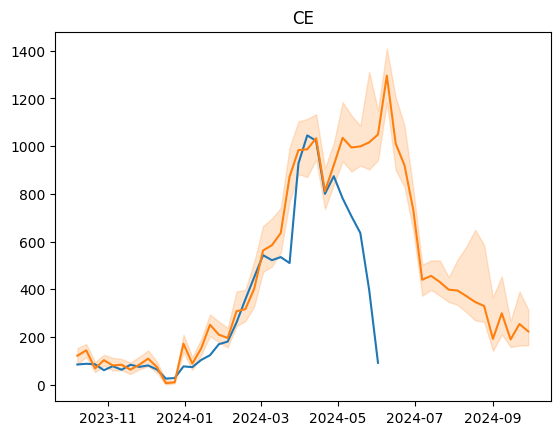

In [19]:
fig, ax = plt.subplots()

ax.plot(df_w.loc[df_w.year == TEST_YEAR].casos, label = 'Data')

ax.plot(df_preds_24.dates, df_preds_24.preds, label = 'preds')

ax.fill_between( df_preds_24.dates, df_preds_24.lower, df_preds_24.upper, color = 'tab:orange', alpha = 0.2)

ax.set_title(f'{STATE}')

plt.show()

Colocando as predições lado a lado:

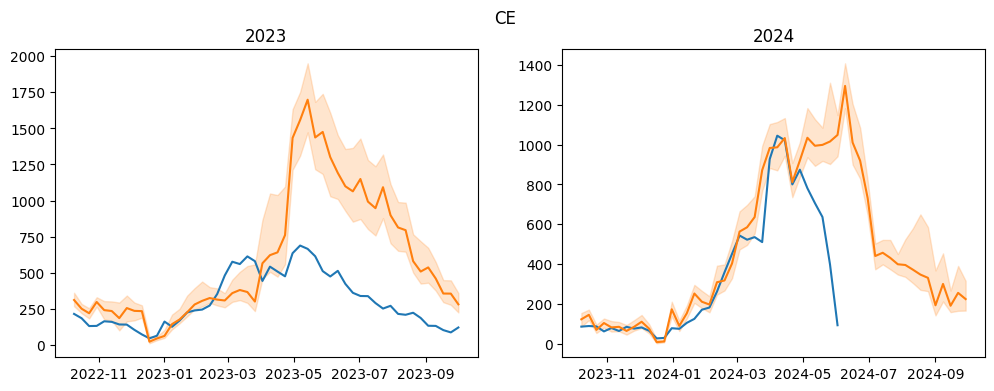

In [20]:
fig, ax = plt.subplots(1,2, figsize = (12, 4))

ax[0].plot(df_w.loc[df_w.year == 2023].casos, label = 'Data')

ax[0].plot(df_preds_23.dates, df_preds_23.preds, label = 'preds')

ax[0].fill_between( df_preds_23.dates, df_preds_23.lower, df_preds_23.upper, color = 'tab:orange', alpha = 0.2)

ax[0].set_title('2023')

ax[1].plot(df_w.loc[df_w.year == 2024].casos, label = 'Data')

ax[1].plot(df_preds_24.dates, df_preds_24.preds, label = 'preds')

ax[1].fill_between( df_preds_24.dates, df_preds_24.lower, df_preds_24.upper, color = 'tab:orange', alpha = 0.2)

ax[1].set_title('2024')

plt.suptitle(f'{STATE}')

plt.show()

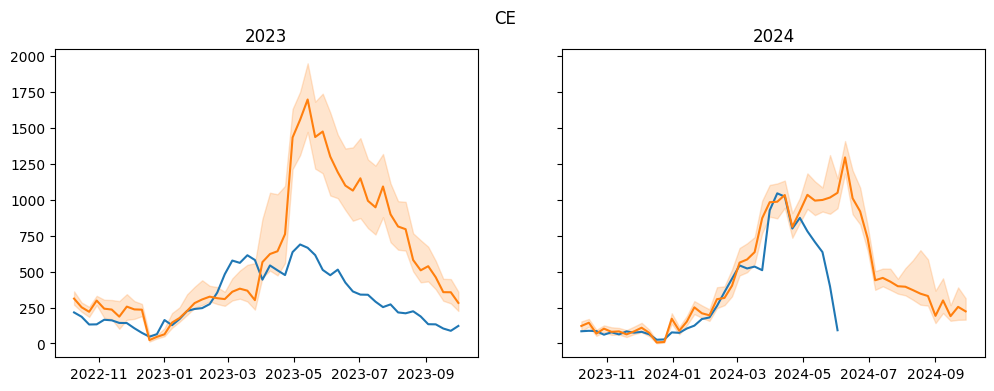

In [21]:
fig, ax = plt.subplots(1,2, figsize = (12, 4), sharey = True)

ax[0].plot(df_w.loc[df_w.year == 2023].casos, label = 'Data')

ax[0].plot(df_preds_23.dates, df_preds_23.preds, label = 'preds')

ax[0].fill_between( df_preds_23.dates, df_preds_23.lower, df_preds_23.upper, color = 'tab:orange', alpha = 0.2)

ax[0].set_title('2023')

ax[1].plot(df_w.loc[df_w.year == 2024].casos, label = 'Data')

ax[1].plot(df_preds_24.dates, df_preds_24.preds, label = 'preds')

ax[1].fill_between( df_preds_24.dates, df_preds_24.lower, df_preds_24.upper, color = 'tab:orange', alpha = 0.2)

ax[1].set_title('2024')

plt.suptitle(f'{STATE}')

plt.show()

In [22]:
df_preds_23.to_csv(f'./predictions/preds_{STATE}_2023_notebook.csv')

df_preds_24.to_csv(f'./predictions/preds_{STATE}_2024_notebook.csv')